In [284]:
import cvxpy as cp
import numpy as np

import torch
import torch.nn as nn
from model import TwolayerNet, MLP, AbstainNet
from torch.utils.data import DataLoader
from utils import load_data

import os
import time
from options import args_parser
from scipy.optimize import milp, Bounds
import matplotlib.pyplot as plt

from scipy.optimize import LinearConstraint

**load data**

In [285]:
class namespace:
    def __init__(self):
        self.batch_size=128
        self.device='cuda:1'
        self.epoch=30000
        self.hidden_dim=300
        self.input_dim=108
        self.load_from_disk=True
        self.lr=0.0005
        self.seed=1
        self.fairness_notion="DP"
        self.attribute="sex"
        self.type_of_abstain="prob"

args = namespace()

args.model_path = "../data/OptimalClassifier"
args.data_path = "../data/adult"

train_data, test_data = load_data(args)

**load functions**

In [294]:
def load_optimal(args):
    model = MLP(args)

    checkpoint = torch.load(os.path.join(args.model_path, "model_state.pth"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model
def load_fair(args):
    model = AbstainNet(args)

    checkpoint = torch.load(os.path.join("../data/FairClassifier/DP_classifier"), map_location="cpu")
    model.load_state_dict(checkpoint)

    model.to("cpu")
    model.eval()

    return model

def load_abstain(args):
    model = AbstainNet(args)
    
    model_file = os.path.join("../data/AbstainClassifier", "abstain_classifier_" + \
                            args.type_of_abstain+"_" + \
                            args.fairness_notion + "_" + \
                            args.attribute + ".pth")
    
    checkpoint = torch.load(model_file, map_location="cpu")
    model.load_state_dict(checkpoint)
    
    model.to("cpu")
    model.eval()
    
    return model

def predict_abstain(model, data, pred_labels):
    X = data.X.numpy()
    X = np.column_stack((X, pred_labels))
    log_probs = model(torch.from_numpy(X).to(torch.float))
    return log_probs.detach().cpu().numpy().flatten()

def predict(model, data):
    log_probs = model(data.X)
    return ((log_probs[:, 1] >= 0.5) * 1).detach().cpu().numpy(), log_probs[:, 1].detach().cpu().numpy()

def formatted(numbers):
    return [f"{num*100:.2f}%" for num in numbers]

def plot_stats(
    y,
    pred_list,
    g1_indices, 
    g2_indices,
    legend = 0.3
):
    num_classifiers = len(pred_list)
    n = pred_list[0][0].shape[0]
    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    
    accu_list = []
    fair_list = []
    ar_list = []
    names = []
    for idx in range(len(pred_list)):
        pred_labels = pred_list[idx][0]
        name = pred_list[idx][-1]
        if len(pred_list[idx]) == 3:
            wn = pred_list[idx][1]
            total_error_sum = np.sum((pred_labels != y) * wn)
            g1_error_sum = np.sum(((pred_labels != y) * wn)[g1_indices])
            g2_error_sum = np.sum(((pred_labels != y) * wn)[g2_indices])
            total_error_rate = total_error_sum / np.sum(wn)
            g1_error_rate = g1_error_sum / np.sum(wn[g1_indices])
            g2_error_rate = g2_error_sum / np.sum(wn[g2_indices])
            
            total_fair = np.sum(pred_labels * wn) / n
            g1_fair = np.sum((pred_labels * wn)[g1_indices]) / g1_num
            g2_fair = np.sum((pred_labels * wn)[g2_indices]) / g2_num
            
            abstain_rate = [1 - np.sum(wn) / n,  
                            1 - np.sum(wn[g1_indices]) / g1_num, 
                            1 - np.sum(wn[g2_indices]) / g2_num]
            
            
        else:
            total_error = pred_labels != y
            g1_error = (pred_labels != y)[g1_indices]
            g2_error = (pred_labels != y)[g2_indices]

            g1_error_rate = np.sum(g1_error) / g1_num
            g2_error_rate = np.sum(g2_error) / g2_num
            total_error_rate = np.sum(total_error) / n

            total_fair = np.sum(pred_labels) / n
            g1_fair = np.sum(pred_labels[g1_indices]) / g1_num
            g2_fair = np.sum(pred_labels[g2_indices]) / g2_num
            
            abstain_rate = [0, 0, 0]
            
        accu_list.append([1 - total_error_rate, 1 - g1_error_rate, 1 - g2_error_rate])
        fair_list.append([total_fair, g1_fair, g2_fair])
        ar_list.append(abstain_rate)
        names.append(name)
        
    plt.rcParams.update({'font.size': 15})

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

    #accuracy
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - int(num_classifiers / 2) * bar_width
    
    for i in range(num_classifiers):
        ax[0,0].bar(start + i * bar_width, accu_list[i], width=bar_width, label=names[i])
        ax[0,0].set_ylim([0.4, 1])
        ax[0,0].set_ylabel("Accuracy")
        ax[0,0].set_title("Accuracy")
        ax[0,0].set_xticks(x_pos)
        ax[0,0].set_xticklabels(x_labels)
        ax[0,0].legend(loc="upper right", framealpha=legend)

    

    #fairness
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - num_classifiers / 2 * bar_width
    for i in range(num_classifiers):
        ax[0,1].bar(start + i * bar_width, fair_list[i], width=bar_width, label=names[i])
        ax[0,1].set_ylabel('$P(\\hat{y} = 1 | G)$')
        ax[0,1].set_title("Demographic Parity")
        ax[0,1].set_xticks(x_pos)
        ax[0,1].set_xticklabels(x_labels)
        ax[0,1].legend(loc="upper right", framealpha=legend)

    #proportion
    ax[1,0].pie([g1_num, g2_num], labels=['G1', 'G2'], autopct='%1.1f%%', startangle=90)
    ax[1,0].set_title('Proportion')

    #abstain rate
    bar_width = 1 / (num_classifiers + 1)
    x_labels = ["Overall", "G1", "G2"]
    x_pos = np.arange(len(x_labels))
    start = x_pos - num_classifiers / 2 * bar_width
    for i in range(num_classifiers):
        if ar_list[i][0] != 0:
            ax[1,1].bar(start + i * bar_width, ar_list[i], width=bar_width, label=names[i])
    ax[1,1].set_ylabel('Abstain Rate')
    ax[1,1].set_title("Abstain Rate")
    ax[1,1].set_xticks(x_pos)
    ax[1,1].set_xticklabels(x_labels)
    ax[1,1].legend(loc="upper right", framealpha=legend)

    fig.savefig('figure_semi_fair.png', bbox_inches='tight')
#     fig.suptitle(args.attribute + " as Sensitive Attribute(G1=Male, G2=Female, "+ '$\delta=$' + str(delta) + ', $\epsilon=$' + str(epsilon) +")", fontsize=30)

    for i in range(num_classifiers):
        print("=="+names[i]+"==\n")
        print("Accuracy", " ".join(formatted(accu_list[i])))
        print("P(\hat{y} = 1 | G)", " ".join(formatted(fair_list[i])))

        print()


**load optimal classifier and get stats**

In [287]:
data = train_data
optimal_classifier = load_optimal(args)
fair_classifier = load_fair(args)
pred_labels, pred_probs = predict(optimal_classifier, data)
# np.save("../data/adult/optimal_labels.npy", pred_labels)
pred_labels_test, _ = predict(optimal_classifier, test_data)
# np.save("../data/adult/test_optimal_labels.npy", pred_labels_test)
pred_fair = (predict_abstain(fair_classifier, data, pred_labels) >= 0.5) * 1
pred_fair_test = (predict_abstain(fair_classifier, test_data, pred_labels_test) >= 0.5) * 1

**IP ptimazation function**

In [288]:
def IP(delta, epsilon, eta, data, pred_labels):

    X = data.X.numpy()
    y = data.y.numpy().astype(int)

    n = X.shape[0]
    g2_indices = np.where(X[:, 64] == 1)[0]
    g1_indices = np.where(X[:, 65] == 1)[0]

    g1_v = (X[:, 65] == 1) * 1
    g2_v = (X[:, 64] == 1) * 1

    g1_num = g1_indices.shape[0]
    g2_num = g2_indices.shape[0]
    total_error = pred_labels != y
    g1_error = (pred_labels != y)[g1_indices]
    g2_error = (pred_labels != y)[g2_indices]
    g1_error_rate = np.sum(g1_error) / g1_num
    g2_error_rate = np.sum(g2_error) / g2_num
    total_error_rate = np.sum(total_error) / n

    a = total_error * 1

    b1 = pred_labels * g1_v
    b2 = pred_labels * g2_v
    c1 = np.stack(
        [
            (b1 / g1_num - b2 / g2_num), 
            (b2 / g2_num - b1 / g1_num),
        ]
    )
    cons1 = epsilon * np.ones(2)

    c2 = np.stack([g1_v, g2_v])
    cons2 = np.array([(1 - delta) * g1_num, (1 - delta) * g2_num])

    a1 = (pred_labels != y) * g1_v
    a2 = (pred_labels != y) * g2_v
    c3 = np.stack([
        (a1 - (g1_error_rate + eta) * g1_v),
        (a2 - (g2_error_rate + eta) * g2_v)
    ])
    cons3 = np.zeros(2)

    lower_bounds = np.zeros_like(a)
    upper_bounds = np.ones_like(a)

    constraints = [
        LinearConstraint(c1, ub=cons1),
        LinearConstraint(c2, lb=cons2),
        LinearConstraint(c3, ub=cons3),
    ]
    integrality = np.ones_like(a)
    res = milp(
        c=a, 
        constraints=constraints, 
        integrality=integrality, 
        bounds=Bounds(lower_bounds, upper_bounds)
    )
    wn = res.x
    return wn

def process_wn(wn, pred_labels):
    if wn is None:
        print("Not feasible!")
        return None
    else:
        plt.plot(np.sort(wn))
        plt.title("$w_n$ for each data point")
        plt.xlabel("data points")
        plt.ylabel("value")
        
        return (wn * pred_labels)
    
def semi_fair(optimal_classifier, fair_classifier, data, p = 0.5):
    pred_optimal, _ = predict(optimal_classifier, data)
    pred_fair = (predict_abstain(fair_classifier, data, pred_labels) >= 0.5) * 1
    
    mask = (pred_optimal != pred_fair)
    c = np.copy(pred_optimal)
    c[mask] = np.where(np.random.random(mask.sum()) < p, pred_fair[mask], c[mask])
    return c

**Solve and plot, tune hyperparameter here**

In [289]:
optimal_classifier = load_optimal(args)
fair_classifier = load_fair(args)

In [290]:
delta_optimal = 0.3
delta_fair = 0.1
delta_semi_fair = 0.2
epsilon = 0.03
eta = 0
p = 0.5

In [291]:
data = train_data
pred_optimal, _ = predict(optimal_classifier, data)
pred_fair = (predict_abstain(fair_classifier, data, pred_labels) >= 0.5) * 1
pred_semi_fair = semi_fair(optimal_classifier, fair_classifier, data, p = 0.5)

In [292]:
X = train_data.X.numpy()
y = train_data.y.numpy().astype(int)
g2_indices = np.where(X[:, 64] == 1)[0]
g1_indices = np.where(X[:, 65] == 1)[0]

# print("Use wn as abstain result\n")

#solve IP
wn_optimal = IP(delta_optimal, epsilon, eta, train_data, pred_optimal)
wn_fair = IP(delta_fair, epsilon, eta, train_data, pred_fair)
wn_semi_fair = IP(delta_semi_fair, epsilon, eta, train_data, pred_semi_fair)


==Opt.==

Accuracy 93.21% 92.30% 95.69%
P(\hat{y} = 1 | G) 49.35% 58.01% 25.92%

==Semi Fair==

Accuracy 92.15% 94.07% 86.96%
P(\hat{y} = 1 | G) 53.05% 58.59% 38.06%

==Fair==

Accuracy 91.11% 95.74% 78.57%
P(\hat{y} = 1 | G) 56.56% 59.19% 49.45%

==Opt. Abstain, $\delta=0.3$==

Accuracy 96.81% 95.66% 99.05%
P(\hat{y} = 1 | G) 28.11% 28.92% 25.92%

==S. Fair Abstain, $\delta=0.2$==

Accuracy 96.14% 99.62% 88.46%
P(\hat{y} = 1 | G) 40.25% 41.05% 38.06%

==Fair Abstain, $\delta=0.1$==

Accuracy 94.26% 100.00% 80.02%
P(\hat{y} = 1 | G) 50.01% 50.82% 47.82%



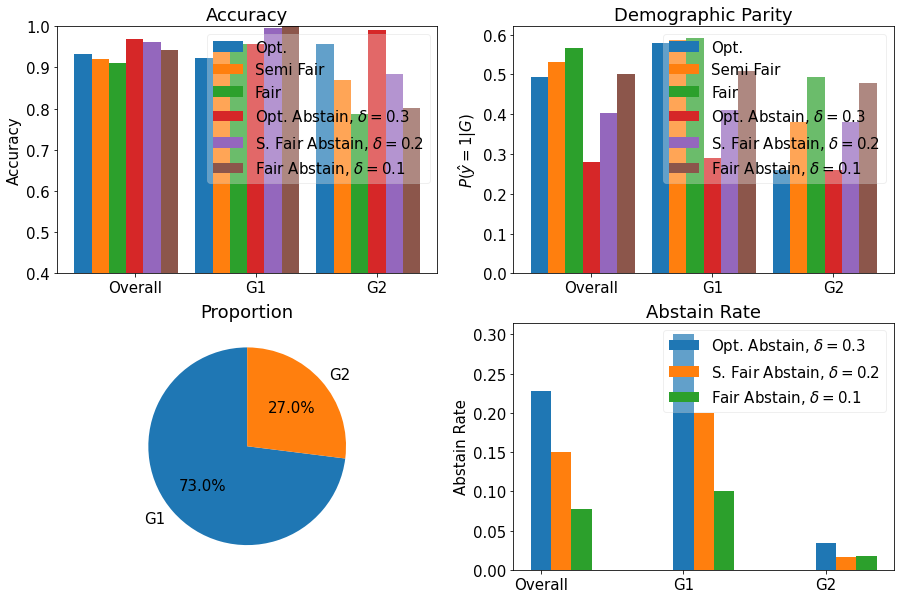

In [295]:
pred_list = [
    [pred_optimal, "Opt."],
    [pred_semi_fair, "Semi Fair"],
    [pred_fair, "Fair"],
    [pred_optimal, wn_optimal, "Opt. Abstain, $\delta=" + str(delta_optimal) + "$"],
    [pred_semi_fair, wn_semi_fair, "S. Fair Abstain, $\delta=" + str(delta_semi_fair) + "$"],
    [pred_fair, wn_fair, "Fair Abstain, $\delta=" + str(delta_fair) + "$"]
]
    
    
plot_stats(
    y,
    pred_list,
    g1_indices, 
    g2_indices)